## Outlier Detection Algorithm with unsupervised Random Forest (RF)
This notebook shows the basic steps for using the outlier detection algorithm we developped, based on unsupervised RF, and its results on simulated 2D data.
The steps of the following notebook include:
* Simulate 2D data on which we will perform the anomaly detection. We call these data *'real'*.

The outlier detection algorithm follows the following steps:
* Build synthetic data with the same sample size as the *'real'* data, and the same marginal distribution in its features. We call these data *'synthetic'*.
* Label the *'real'* data as Class I and the *'synthetic'* data as Class II. Merge the two samples with their labels into a data matrix **X** and label vector **Y**.
* Train the RF to distinguish between Class I and Class II.
* Once we have the trained forest, we propogate the *'real'* data through the RF to obtain a pair-wise distance for all the objects in our sample.
* Sum the distances from a given object to all the rest to obtain the final weirdness score.
* Sort the weirdness score vector and extract the N weirdest objects in the sample.

In [1]:
%pylab inline
import numpy
import sklearn
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


## Simulating 2D data for anomaly detection
In the next cell we will simulate the data on which we will perform outlier detection. 
We use 2D data for illustration purposes. If you have trouble constructing your input data on which to perform outlier detection, please let us know (dalyabaron@gmail.com) and we will help!

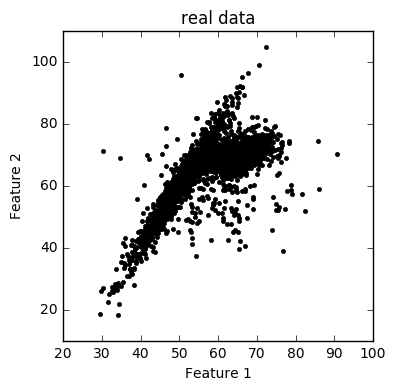

In [50]:
mean = [50, 60]
cov = [[5,5],[100,200]]
x1,y1 = numpy.random.multivariate_normal(mean,cov,1000).T

mean = [65, 70]
cov = [[20,10],[2,10]]
x2,y2 = numpy.random.multivariate_normal(mean,cov,1000).T

# and additional noises
mean = [60, 60]
cov = [[100,0],[0,100]]
x3,y3 = numpy.random.multivariate_normal(mean,cov,200).T

# concatenate it all to a single vector
x_total = numpy.concatenate((x1, x2, x3))
y_total = numpy.concatenate((y1, y2, y3))
X = numpy.array([x_total, y_total]).T
# create object IDs that will be just integers 
obj_ids = numpy.arange(len(x_total))

plt.rcParams['figure.figsize'] = 4, 4
plt.title("real data")
plt.plot(X[:, 0], X[:, 1], "ok", markersize=3)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

## Outlier detection algorithm
We wish to detect the outlying objects in the given 2D data from the previous cell (which we call *'real'*). We will do that step by step in the following cells.

**Step 1:** create synthetic data with the same sample size as the *'real'* data, and the same marginal distributions in its features. We call these data *'synthetic'*.

We build the *'synthetic'* data with **the same size** as the *'real'* data because we want the RF to train on a balanced sample. That is, the RF performs better when the different classes have approximatly the same number of objects. Otherwise, the trained forest will perform better on the bigger class and worse on the smaller class.

We build the *'synthetic'* data with the same marginal distributions because we wish to detect objects with outlying covariance (and higher moments). We show in the paper that this method works best for anomaly detection on galaxy spectra. Other possible choices are discussed by Shi & Horvath (2006).

In [51]:
def return_synthetic_data(X):
    """
    The function returns a matrix with the same dimensions as X but with synthetic data
    based on the marginal distributions of its featues
    """
    features = len(X[0])
    X_syn = numpy.zeros(X.shape)

    for i in xrange(features):
        obs_vec = X[:,i]
        syn_vec = numpy.random.choice(obs_vec, len(obs_vec)) # here we chose the synthetic data to match the marginal distribution of the real data
        X_syn[:,i] += syn_vec

    return X_syn

X_syn = return_synthetic_data(X)

Now lets plot the *'real'* and *'synthetic'* data to examine the properties of the *'synthetic'* data:

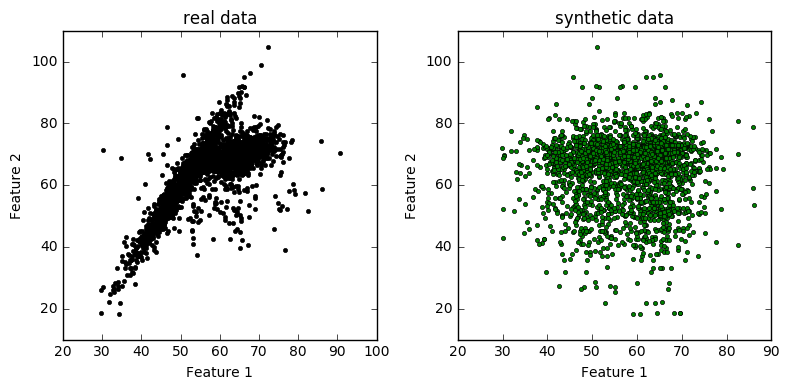

In [52]:
plt.rcParams['figure.figsize'] = 8, 4

plt.subplot(1, 2, 1)
plt.title("real data")
plt.plot(X[:, 0], X[:, 1], "ok", markersize=3)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.subplot(1, 2, 2)
plt.title("synthetic data")
plt.plot(X_syn[:, 0], X_syn[:, 1], "og", markersize=3)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()

Now lets plot the marginal distributions of the *'real'* and *'synthetic'* data and make sure that they match for a given feature:

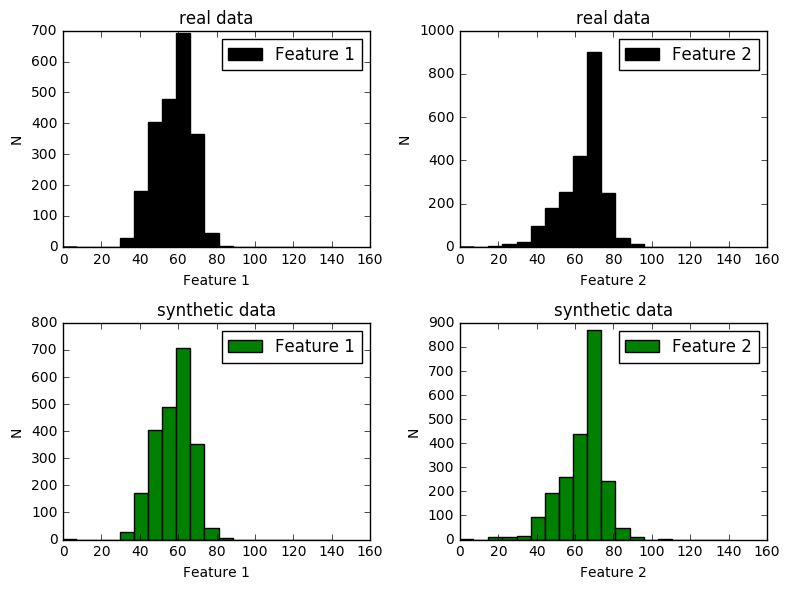

In [53]:
plt.rcParams['figure.figsize'] = 8, 6

plt.subplot(2, 2, 1)
plt.title("real data")
tmp = plt.hist(X[:, 0], bins=numpy.linspace(0, 140, 20), color="k", label="Feature 1")
plt.legend(loc="best")
plt.xlabel("Feature 1")
plt.ylabel("N")

plt.subplot(2, 2, 2)
plt.title("real data")
tmp = plt.hist(X[:, 1], bins=numpy.linspace(0, 140, 20), color="k", label="Feature 2")
plt.legend(loc="best")
plt.xlabel("Feature 2")
plt.ylabel("N")

plt.subplot(2, 2, 3)
plt.title("synthetic data")
tmp = plt.hist(X_syn[:, 0], bins=numpy.linspace(0, 140, 20), color="g", label="Feature 1")
plt.legend(loc="best")
plt.xlabel("Feature 1")
plt.ylabel("N")

plt.subplot(2, 2, 4)
plt.title("synthetic data")
tmp = plt.hist(X_syn[:, 1], bins=numpy.linspace(0, 140, 20), color="g", label="Feature 2")
plt.legend(loc="best")
plt.xlabel("Feature 2")
plt.ylabel("N")

plt.tight_layout()

**Step 2:** Once we have the *'real'* and *'synthetic'* data, we merge them into a single sample and assign classes to each of these. We will then train an RF to distinguish between the different classes.
This step essentially converts the problem from unsupervised to supervised, since we have labels for the data.

We train the forest on the **entire** data, without dividing it to training, validation, and test sets as typically done in supervised learning. This is because we do not need to test the algorithms performance on new data, but we need it to learn as much as possible from the input (*'real'*) data in order to detect outliers.

In this demo we **do not perform parallel training** since the sample is small. In case of parallel training one must:
* Select a random subset of objects from X.
* Select a random subset of features from X.
* Build *'synthetic'* data with the same dimensions as the subset of the *'real'* data.
* Train N decision trees for this *'real'* and *'synthetic'* data.
* Repeat the process M times, each time with a new subset of objects and features.
* Merge all the decision trees into a forest, the forest will contain NxM decision trees.

In [54]:
def merge_work_and_synthetic_samples(X, X_syn):
    """
    The function merges the data into one sample, giving the label "1" to the real data and label "2" to the synthetic data
    """
    # build the labels vector
    Y = numpy.ones(len(X))
    Y_syn = numpy.ones(len(X_syn)) * 2

    Y_total = numpy.concatenate((Y, Y_syn))
    X_total = numpy.concatenate((X, X_syn))
    return X_total, Y_total

X_total, Y_total = merge_work_and_synthetic_samples(X, X_syn)
# declare an RF
N_TRAIN = 500 # number of trees in the forest
rand_f = sklearn.ensemble.RandomForestClassifier(n_estimators=N_TRAIN)
rand_f.fit(X_total, Y_total)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Lets plot the probability of an object, which is described by the coordiantes (Feature 1, Feature 2), to be classified as *'real'* by the trained RF. This will give us a sense of the fitting that is done.

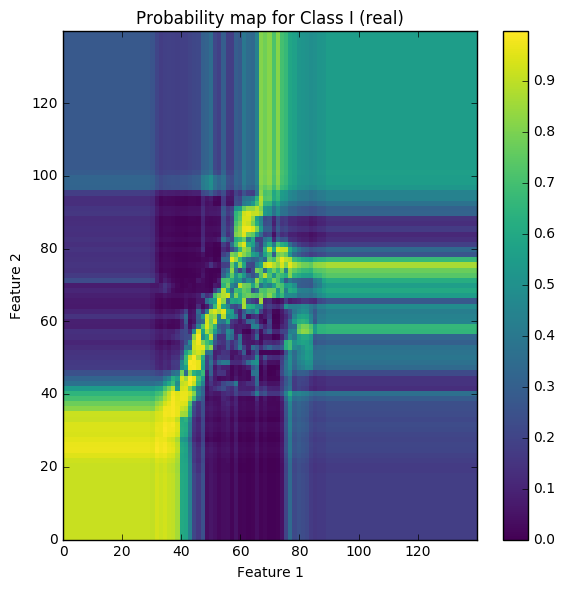

In [55]:
xx, yy = numpy.meshgrid(numpy.linspace(0, 140, 100), numpy.linspace(0, 140, 100))
Z = rand_f.predict_proba(numpy.c_[xx.ravel(), yy.ravel()])[:, 0]
Z = Z.reshape(xx.shape)

plt.rcParams['figure.figsize'] = 6, 6
plt.pcolormesh(xx, yy, Z, cmap='viridis')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()
plt.title("Probability map for Class I (real)")
plt.xticks((0, 20, 40, 60, 80, 100, 120))
plt.yticks((0, 20, 40, 60, 80, 100, 120))
plt.xlim(0, 140)
plt.ylim(0, 140)

plt.tight_layout()

One can see that in the parameter range of Feature 1: 40-80, and Feature 2: 40-100, the classifier performs well and is able to describe the boundries of the *'real'* data well. This is not true outside this range, since we do not have *'real'* data there. However, this is not an issue since we wish to detect outliers where *'real'* actually exists.

**Step 3:** Having a trained RF, we now build the similarity matrix that describes the pair-wise similarity of all the *'real'* objects in our sample. We note that from this point, we do not need the *'synthetic'* data any more.

The algorithm presented by Shi & Horvath (2006) propagates each pair of objects in the decision trees and counts how many times these objects ended up in the same terminal node (leaf). Since a leaf in the tree describes the same route inside the tree, objects that end up in the same leaf are described by the same model within the same tree and therefore are similar. The similarity measure can vary from 0 (objects never end up in the same leaf) to N_trees (objects ended up in the same leaf in all the decision trees).

The next cell shows the schematic process of measuring the similarity measure:

In [19]:
import io
import base64
from IPython.display import HTML

video = io.open('rf_unsup_example.m4v', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In our case, we find that counting all the leafs, regardless of their prediction, is not optimal.
Instead, we propagate the objects through the decision trees and count how many times these objects ended up in the same leaf which **ALSO** predicts both of the objects to be real.
In our demo example this does not change the outliers that we get, but for outlier detection on galaxy spectra we find that galaxies with very low signal-to-noise ratio (essentially no signal detected), which are often predicted to be *'synthetic'* by the algorithm, add significant noise to the final distance measure.
In the next cells we compute the similarity matrix when taking into account only leaves that predict both of the objects to be *'real'*:

In [56]:
def build_similarity_matrix(rand_f, X):
    """
    The function builds the similarity matrix based on the feature matrix X for the results Y
    based on the random forest we've trained
    the matrix is normalised so that the biggest similarity is 1 and the lowest is 0

    This function counts only leaves in which the object is classified as a "real" object 
    it is also implemented to optimize running time, asumming one has enough running memory
    """
    # apply to get the leaf indices
    apply_mat = rand_f.apply(X)
    # find the predictions of the sample
    is_good_matrix = numpy.zeros(apply_mat.shape)
    for i, est in enumerate(rand_f.estimators_):
        d = est.predict_proba(X)[:, 0] == 1
        is_good_matrix[:, i] = d
    # mark leaves that make the wrong prediction as -1, in order to remove them from the distance measurement
    apply_mat[is_good_matrix == False] = -1 
    # now calculate the similarity matrix
    sim_mat = numpy.sum((apply_mat[:, None] == apply_mat[None, :]) & (apply_mat[:, None] != -1) & (apply_mat[None, :] != -1), axis=2) / numpy.asfarray(numpy.sum([apply_mat != -1], axis=2), dtype='float')
    return sim_mat

sim_mat = build_similarity_matrix(rand_f, X)
dis_mat = 1 - sim_mat

We defined the distance matrix to be 1 - the similarity matrix. 
The definition of the distance matrix should obey the triangle inequality and should preserve the inner ordering of the data. Therefore, there are different distance definitions that will result in the same outlier ranking (such as square root of 1 - the similarity matrix).

**Step 4:** Here we sum the distance matrix. This is essentialy the weirdness score. Objects that have on average large distances from the rest will have a higher sum, therefore a higher weirdness score.

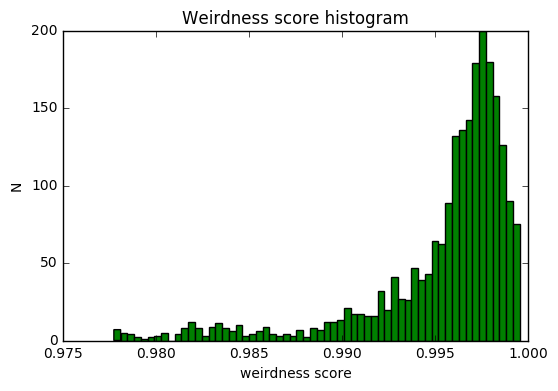

In [58]:
sum_vec = numpy.sum(dis_mat, axis=1)
sum_vec /= float(len(sum_vec))

plt.rcParams['figure.figsize'] = 6, 4
plt.title("Weirdness score histogram")
tmp = plt.hist(sum_vec, bins=60, color="g")
plt.ylabel("N")
plt.xlabel("weirdness score")

We can see that for this dataset most of the objects have an average distance of 0.998 from each other, and outliers are objects with average distance that approaches 1. 
We show in the paper that for the entire SDSS galaxy sample, the weirdness distribution decreases for increasing weirdness score.

Lets plot the 200 most outlying objects in our sample:

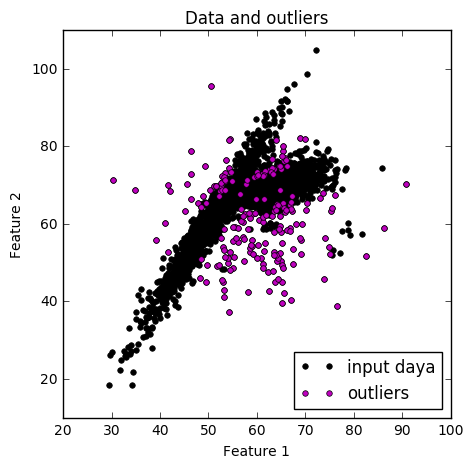

In [59]:
N_outliers = 200
sum_vec_outliers = numpy.sort(sum_vec)[::-1][:N_outliers]
obj_ids_outliers = obj_ids[numpy.argsort(sum_vec)][::-1][:N_outliers]

plt.rcParams['figure.figsize'] = 5, 5
plt.title("Data and outliers")
plt.plot(X[:,0], X[:,1], "ok", label="input daya", markersize=4)
plt.plot(X[obj_ids_outliers, 0], X[obj_ids_outliers, 1], "om", label="outliers", markersize=4)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")	
plt.legend(loc="best")

One can see that not **ALL** outlier points are classified as outliers by the algorithm.
This is due to the randomness of the algorithm, which result in different outliers for each run of the algorithm. 
We recommend running the algorithm a number of times, if you have enough CPU time available, and averaging the weirdness score.
However, one can see that the tails of the inlier distribution are marked as outliers, as we also find with the SDSS galaxies.